C:\Users\jvgat\AppData\Local\Temp\ipykernel_8660\2951766668.py:7: DtypeWarning: Columns (34,35,36,37,39,40,41,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/jvgat/Downloads/Hazard/df_after_feature_engineering.csv")


Cross-listing count distribution:
count    127515.000000
mean          1.445155
std           0.497048
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: cross_listing_count, dtype: float64

CWE risk factor distribution:
count    127515.000000
mean          0.005289
std           0.009339
min           0.000000
25%           0.000576
50%           0.001830
75%           0.008772
max           1.000000
Name: cwe_risk_factor, dtype: float64

New strata distribution:
cross_listing_count_cat  cwe_risk_category
low                      low                  25843
                         medium               21011
                         high                 23901
medium                   low                  21075
                         medium               17629
                         high                 18052
high                     low                      1
                         high                     3
dt

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a


Model Summary:
                                 coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                    
base_score                   0.449393   1.567360  0.028724        0.393094   
repo_publication_lag_sqrt   -0.000010   0.999990  0.000002       -0.000015   
cross_listing_variance_sqrt -0.127570   0.880232  0.096746       -0.317188   

                             coef upper 95%  exp(coef) lower 95%  \
covariate                                                          
base_score                         0.505691             1.481558   
repo_publication_lag_sqrt         -0.000006             0.999985   
cross_listing_variance_sqrt        0.062048             0.728194   

                             exp(coef) upper 95%  cmp to          z  \
covariate                                                             
base_score                              1.658131     0.0  15.645054   
repo_publication_lag_sqrt              

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2744: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, _df in self._predicted_partial_hazards_.groupby(self.strata):



Concordance index: 0.6890885629014235

Valid strata for prediction (8 combinations):
  - ('low', 'low')
  - ('low', 'medium')
  - ('low', 'high')
  - ('medium', 'low')
  - ('medium', 'medium')
  - ('medium', 'high')
  - ('high', 'low')
  - ('high', 'high')

Example Predictions

Risk predictions for different CVE profiles:
  cross_listing_count_cat cwe_risk_category  kev_prob_30d  kev_prob_90d  \
0                     low               low        0.0000        0.0000   
1                     low            medium        0.0000        0.0000   
2                  medium            medium        0.0187        0.0242   
3                  medium              high        0.0804        0.0982   

   kev_prob_365d  
0         0.0000  
1         0.0000  
2         0.0373  
3         0.1470  


Predictions for real non-KEV CVEs:
  cross_listing_count_cat cwe_risk_category  kev_prob_30d  kev_prob_365d
0                     low            medium        0.0000         0.0000
1                    

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):


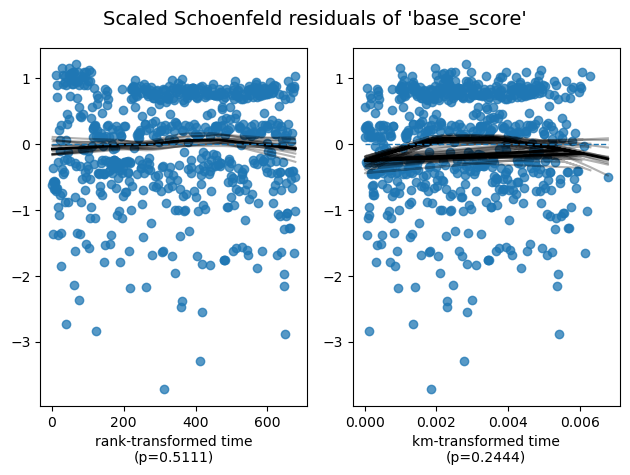

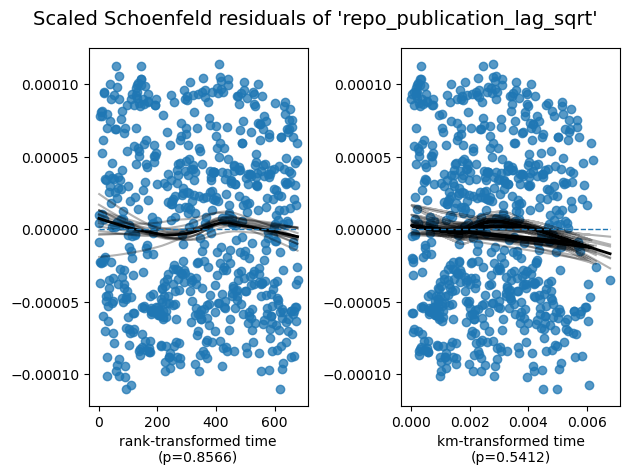

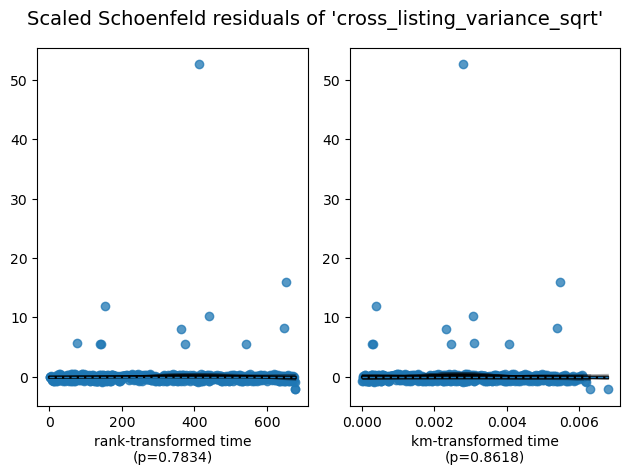

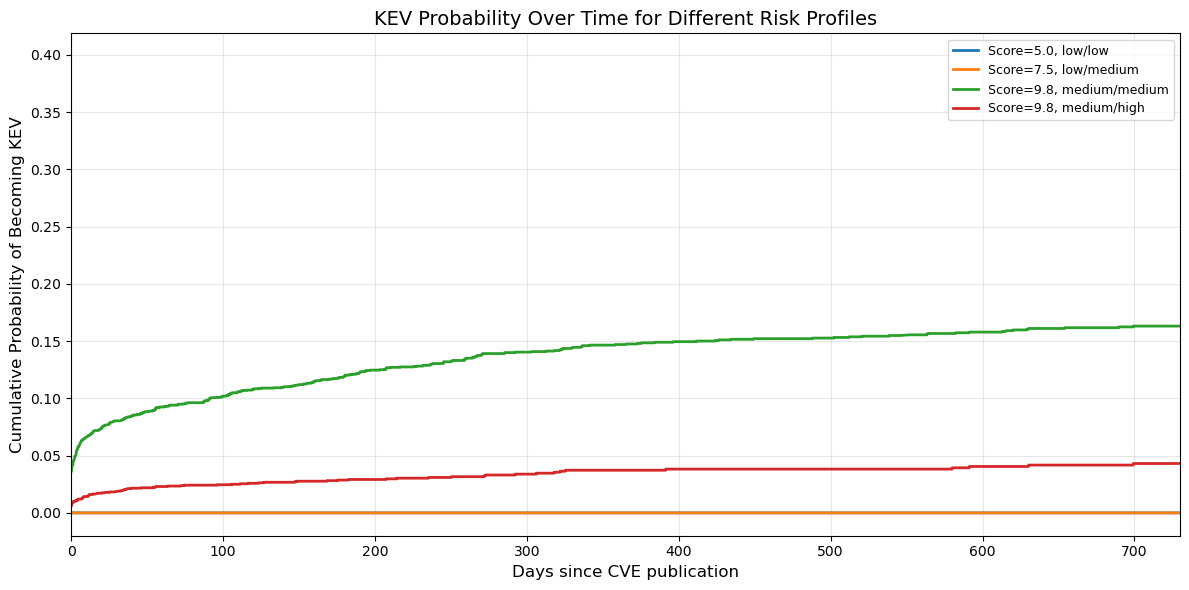

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("C:/Users/jvgat/Downloads/Hazard/df_after_feature_engineering.csv")
date_cols = ['published_date','kev_published']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

df['time_to_event'] = (df['kev_published'] - df['published_date']).dt.total_seconds() / (60*60*24)
df['event'] = df['kev_present']
df.loc[df['event'] == 0, 'time_to_event'] = (pd.Timestamp.now(tz='UTC') - df.loc[df['event'] == 0, 'published_date']).dt.total_seconds() / (60*60*24)

features = ['base_score', 'repo_publication_lag', 'cross_listing_count','cross_listing_variance', 'cwe_risk_factor']
df_model = df[features + ['time_to_event', 'event']].dropna().copy()

# Apply transformations
df_model['repo_publication_lag_sqrt'] = df_model['repo_publication_lag'].rank()
df_model['cross_listing_variance_sqrt'] = np.sqrt(df_model['cross_listing_variance'])

# FIXED: Better categorization based on actual data distribution
print("Cross-listing count distribution:")
print(df_model['cross_listing_count'].describe())
print("\nCWE risk factor distribution:")
print(df_model['cwe_risk_factor'].describe())

# Create categories that actually have data
df_model['cross_listing_count_cat'] = pd.cut(
    df_model['cross_listing_count'], 
    bins=[0, 1, 2, float('inf')],  # Adjusted bins
    labels=['low', 'medium', 'high']
)

df_model['cwe_risk_category'] = pd.qcut(
    df_model['cwe_risk_factor'], 
    q=3,  # Reduced to 3 categories
    labels=['low', 'medium', 'high'],
    duplicates='drop'
)

# Verify the new distribution
print("\nNew strata distribution:")
strata_counts = df_model.groupby(['cross_listing_count_cat', 'cwe_risk_category'], observed=True).size()
print(strata_counts)
print(f"\nNumber of valid strata: {len(strata_counts[strata_counts > 0])}")

# Define transformed features and columns to include
transformed_features = ['base_score', 'repo_publication_lag_sqrt', 
                       'cross_listing_variance_sqrt']

model_cols = transformed_features + ['time_to_event', 'event', 
                                     'cross_listing_count_cat', 'cwe_risk_category']

df_final = df_model[model_cols].copy()

# Fit model with fixed stratification
cph = CoxPHFitter()
cph.fit(df_final, 
        duration_col='time_to_event', 
        event_col='event',
        strata=['cross_listing_count_cat', 'cwe_risk_category'])

print("\n" + "="*50)
print("Model Summary:")
print("="*50)
print(cph.summary)

# Check assumptions
cph.check_assumptions(df_final, 
                      columns=transformed_features, 
                      p_value_threshold=0.05, 
                      show_plots=True)

print(f"\nConcordance index: {cph.concordance_index_}")

# ============================================
# PREDICTION FUNCTIONS
# ============================================

def get_available_strata(cph, df_training):
    """Get all valid strata combinations from training data"""
    strata_cols = cph.strata if cph.strata else []
    if not strata_cols:
        return None
    
    valid_strata = df_training.groupby(strata_cols, observed=True).size()
    valid_strata = valid_strata[valid_strata > 0].index.tolist()
    return valid_strata

def predict_kev_probability(cph, new_cve_data, time_points=None):
    """
    Predict probability of becoming KEV for new CVEs
    """
    if time_points is None:
        time_points = np.array([30, 90, 180, 365, 730])
    
    # Get survival function
    surv_funcs = cph.predict_survival_function(new_cve_data)
    
    # Extract probabilities at specific time points
    results = []
    for idx in new_cve_data.index:
        surv_func = surv_funcs[idx]
        probs = {'cve_id': idx}
        
        # Add strata information
        if cph.strata:
            for col in cph.strata:
                probs[col] = new_cve_data.loc[idx, col]
        
        for t in time_points:
            surv_prob = surv_func.loc[surv_func.index <= t].iloc[-1] if any(surv_func.index <= t) else 1.0
            kev_prob = 1 - surv_prob
            probs[f'kev_prob_{int(t)}d'] = kev_prob
            probs[f'survival_prob_{int(t)}d'] = surv_prob
        
        results.append(probs)
    
    return pd.DataFrame(results)


# ============================================
# EXAMPLES
# ============================================

# Get valid strata
valid_strata = get_available_strata(cph, df_final)
print(f"\nValid strata for prediction ({len(valid_strata)} combinations):")
for stratum in valid_strata:
    print(f"  - {stratum}")

# Example 1: Predict for different risk profiles
print("\n" + "="*50)
print("Example Predictions")
print("="*50)

# Create realistic test cases using valid strata
test_cases = pd.DataFrame({
    'base_score': [5.0, 7.5, 9.8, 9.8],
    'repo_publication_lag_sqrt': [10, 50, 100, 150],
    'cross_listing_variance_sqrt': [0.5, 1.0, 1.5, 2.0],
    'cross_listing_count_cat': ['low', 'low', 'medium', 'medium'],
    'cwe_risk_category': ['low', 'medium', 'medium', 'high']
})

predictions = predict_kev_probability(cph, test_cases)
print("\nRisk predictions for different CVE profiles:")
print(predictions[['cross_listing_count_cat', 'cwe_risk_category', 
                   'kev_prob_30d', 'kev_prob_90d', 'kev_prob_365d']].round(4))


# Example 2: Predict for actual non-KEV CVEs
non_kev_sample = df_final[df_final['event'] == 0].sample(n=min(5, len(df_final[df_final['event'] == 0])), random_state=42)
non_kev_features = non_kev_sample[['base_score', 'repo_publication_lag_sqrt', 
                                     'cross_listing_variance_sqrt',
                                     'cross_listing_count_cat', 'cwe_risk_category']]

predictions_real = predict_kev_probability(cph, non_kev_features)
print("\n\nPredictions for real non-KEV CVEs:")
print(predictions_real[['cross_listing_count_cat', 'cwe_risk_category', 
                        'kev_prob_30d', 'kev_prob_365d']].round(4))


# Example 3: Visualize survival curves
fig, ax = plt.subplots(figsize=(12, 6))

surv_funcs = cph.predict_survival_function(test_cases)
for i, (idx, surv) in enumerate(surv_funcs.items()):
    label = f"Score={test_cases.iloc[i]['base_score']}, " + \
            f"{test_cases.iloc[i]['cross_listing_count_cat']}/{test_cases.iloc[i]['cwe_risk_category']}"
    ax.plot(surv.index, 1 - surv.values,  # Plot KEV probability instead of survival
            label=label, linewidth=2)

ax.set_xlabel('Days since CVE publication', fontsize=12)
ax.set_ylabel('Cumulative Probability of Becoming KEV', fontsize=12)
ax.set_title('KEV Probability Over Time for Different Risk Profiles', fontsize=14)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 730)
plt.tight_layout()
plt.show()